#Introduction


##In this practice we are going to use an algorithm based on a herarchic Bayesian model to infer the age-metallicity distribution of a sample of stars from the Pleidaes open cluster.



#Gaia EDR3: The sample is selected using the following query:

SELECT*
FROM gaiaedr3.gaia_source AS gaia
WHERE contains(POINT('ICRS', 56.75, 24.12),CIRCLE('ICRS',gaia.ra, gaia.dec, 5)) = 1
AND sqrt(power(gaia.pmra - 20.5, 2) + power(gaia.pmdec + 45.5, 2)) < 6.0
AND ruwe<=1.4
AND phot_bp_rp_excess_factor < 1.25 + 0.052*power(bp_rp,2) - 0.0045*power(bp_rp,3)

##Code for 3D plots

###This script plots the AMD in a 3D bar representation. The high of each bar refers to the 50th persentile of the posterior marginal distribution.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('classic')

def list_ticks(x):
    x_tk=[]
    for i in x:
        if i%1.==0.:
            x_tk.append(str(int(i)))
        else:
            x_tk.append(str(i))
            
    return x_tk

Zw = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.004, 0.006, 0.008, 0.010, 0.014, 0.017, 0.020, 0.030, 0.040]
N_zw = len(Zw)
color_map = plt.cm.gist_rainbow(np.linspace(0., 1., N_zw))
colors={ Zw[i] : color_map[i] for i in range(N_zw)}


################################################################################
################################################################################

def sfh_plot_mode(name, Z0, age0, SFR0, typ, fig):

    Z = np.unique(Z0)
    Nz=len(Z)
    idx_Z = range(1,Nz+1)

    ages = np.unique(age0)
    age_list = list_ticks(np.round(ages,1))

    Nag=len(ages)
    ages_aux=np.arange(1,Nag+1)
    
    niso = Nz*Nag

    ### plot ###
    ax = fig.add_subplot(131, projection='3d',autoscale_on=True)

    nn=1
    for zn in Z:
        sfr = SFR0[np.where(Z0==zn)]
        cs = [colors[zn]] * len(ages)
        plt.bar(ages_aux-0.2, sfr, width=0.3, zs=nn, zdir='x', align='center', color=cs, alpha=0.8, linewidth=0)
        nn = nn + 1

    ax.view_init(30, -135)
    sz=10
    ax.set_xlabel('Z')
    ax.set_ylabel('Age (Gyr)')
    ax.set_zlabel('Stellar Fraction')


    idx_Z = np.arange(1,4)
    plt.xticks(idx_Z, ('0.014', '0.017', '0.020'))
    plt.yticks(ages_aux, ('0.03','0.06','0.10','0.18','0.32','0.56','1.00'))


    plt.xlim(min(idx_Z)-0.5,max(idx_Z)+0.5)
    
    
    plt.ylim(min(ages_aux)-0.5,max(ages_aux)+0.5)

    #ax.set_zlim(0., 1.)

    plt.tight_layout()

##Code for stats

###Script to calculate the percentiles.

In [2]:
from scipy.optimize import minimize
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

#############################################
################# HISTOGRAM #################
#############################################

def a_stat(a):

    Na=len(a)

    perc = []
    for i in range(Na):

        p = np.percentile(a[i],[0,50,100])

        perc.append([p[0], p[1], p[2]])

    perc = np.array(perc)
#    Nzeros=len(perc[0])
#    perc[0] = np.zeros(Nzeros)
#    perc[-1] = np.zeros(Nzeros)

    return perc

##Code to visualise marginal distributions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
from scipy.optimize import minimize
from scipy import stats
#import a_statistics_def_fun as st_def
plt.style.use('classic')

def a_stat(a):

    Na=len(a)

    perc = []
    for i in range(Na):

        p = np.percentile(a[i],[0,50,100])

        perc.append([p[0], p[1], p[2]])

    perc = np.array(perc)
    #Nzeros=len(perc[0])
    #perc[0] = np.zeros(Nzeros)
    #perc[-1] = np.zeros(Nzeros)

    return perc

def list_ticks(x):
    x_tk=[]
    for i in x:
        if i%1.==0.:
            x_tk.append(str(int(i)))
        else:
            x_tk.append(str(i))
            
    return x_tk

##################

def marg_Z(ax, nag, n_z):
    a_mar = []
    x1, x2 = 0, nag
    for i in range(n_z):
        a_mar.append(np.sum(ax[x1:x2]))
        x1+=nag
        x2+=nag
    return np.array(a_mar)


def marg_AGE(ax, nag):
    a_mar = []
    x1, x2 = 0, nag
    for i in range(nag):
        a_mar.append(np.sum(ax[i::nag]))
    return np.array(a_mar)


################################################################################
################################################################################
################################################################################

def marg_sfh_bar_age(name,sfh,a_sp,fig):

    Z0, age0, mode = sfh[0], sfh[1], sfh[4]

    Z = np.unique(Z0)
    Nz=len(Z)
    idx_Z = range(1,Nz+1)

    age = np.unique(age0)
    age_list = list_ticks(np.round(age,1))
    Nag=len(age)
    age_aux= np.arange(1,Nag+1)

    SFR_mode_marg = marg_AGE(mode, Nag)
    
    ##
    a_age = []
    cont=0
    for ai in a_sp:
        a_aux = marg_AGE(ai, Nag)
        a_age.append(a_aux)

    a_age = np.array(a_age)

    #perc = st_def.a_stat(a_age.T)
    perc = a_stat(a_age.T)
    ##

    sfh_mgl=[]
    for i in range(Nag):
        sfh_mgl.append([age_aux[i], SFR_mode_marg[i], perc[i][0], perc[i][1], perc[i][2]])
    sfh_mgl = np.array(sfh_mgl)
    
    sfh_mgl = sfh_mgl.T
    

    
    ###########################################

    ax = fig.add_subplot(132)

    violin_parts = ax.violinplot(a_age, positions=age_aux, showmedians=True)
    
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

    # Make the violin body blue with a red border:
    for vp in violin_parts['bodies']:
        vp.set_facecolor('y')
        vp.set_edgecolor('black')
        vp.set_linewidth(1)
        vp.set_alpha(0.3)

    
    labels = age_list
    ax.set_xticks(np.arange(1,len(labels) + 1))
    ax.set_xticklabels(labels)
    
    ax.set_xlim(age_aux[-1]+0.5,age_aux[0]-0.5)
    ax.set_ylim(0.,1.)

    ax.set_xlabel('Age(Gyr)')
    ax.set_ylabel('$a_{AGE}$', fontsize=15)
    

    

################################################################################
################################################################################
################################################################################


def marg_sfh_bar_Z(name,sfh,a_sp, niso,fig):

    Z0, age0, mode = sfh[0], sfh[1], sfh[2]

    Z = np.unique(Z0)
    Z_list = list_ticks(Z)
    Nz=len(Z)
    idx_Z = range(1,Nz+1)

    age = np.unique(age0)
    Nag=len(age)
    age_int = np.append(0.,age)
    
    SFR_mode_marg = marg_Z(mode, Nag, Nz)

    ##
    a_z = []
    for ai in a_sp:
        a_z.append(marg_Z(ai, Nag, Nz))
    a_z = np.array(a_z)
    perc = a_stat(a_z.T)

    ##
    sfh_mgl=[]
    for i in range(Nz):
        sfh_mgl.append([idx_Z[i], SFR_mode_marg[i], perc[i][0], perc[i][1], perc[i][2]])
    sfh_mgl = np.array(sfh_mgl)

    sfh_mgl = sfh_mgl.T
    
    ###########################################
    ###########################################
    
    ax = fig.add_subplot(133)

    violin_parts = ax.violinplot(a_z, positions=idx_Z, showmedians=True)

    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

    # Make the violin body blue with a red border:
    for vp in violin_parts['bodies']:
        vp.set_facecolor('y')
        vp.set_edgecolor('black')
        vp.set_linewidth(1)
        vp.set_alpha(0.3)
    

    labels = ['0.014', '0.017', '0.020']

    tk=np.arange(1, len(labels) + 1)
    ax.set_xticks(tk)
    ax.set_xticklabels(labels)
    ax.set_xlim(tk[0]-0.5,tk[-1]+0.5)

    ax.set_ylim(0.,1.0)
    
    ax.set_xlabel('Z')
    ax.set_ylabel('$a_Z$', fontsize=15)

#Selection effects


##We should infer the AMD of the Pleiades sample for stars brighter than G=20 mag and G=15, S20 y S15.


###1) Does the solution changes between S20 and S15? What are the differences?


###2) There is a degeneration problem for the inference with S20. Is it solved with S15? If so, why is the problem solved?

#Model dependencies: AMD-IMF


###3) Does the solution changes between Salpeter and Kroupa? Is there a correlations between ages and the IMF?

##SFH Sampling for limiting magnitudes of 20 mag in each Gaia band

###Main body of the algorithm. This consist of three sections: 1) Statistical model, 2) posterior sampling and 3) statatistical plots.

file:  https://raw.githubusercontent.com/sundarjhu/DAWGI_Lectures_2021/main/Demo_DAWGI_HBM/Pleiades/Pleiades_ruwe_cexcess_SelDist.txt
N_iso =  21
N_col =  4
N_dat =  1234
 
Calculating Cij ...
C_ij =  1234 21
Cij end.
 
Calculating Pij ...
0.0 %
16.207455429497568 %
32.414910858995135 %
48.62236628849271 %
64.82982171799027 %
81.03727714748784 %
97.24473257698541 %


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5aa9e300ef531ddf608f7d7838acb099 NOW.


0.4811198115348816 mins
P_ij =  1234 21
Pij end.
 
model.pkl does not exist
Star sampling
319.56897377967834 s
a_col = 21
a_row = 25000


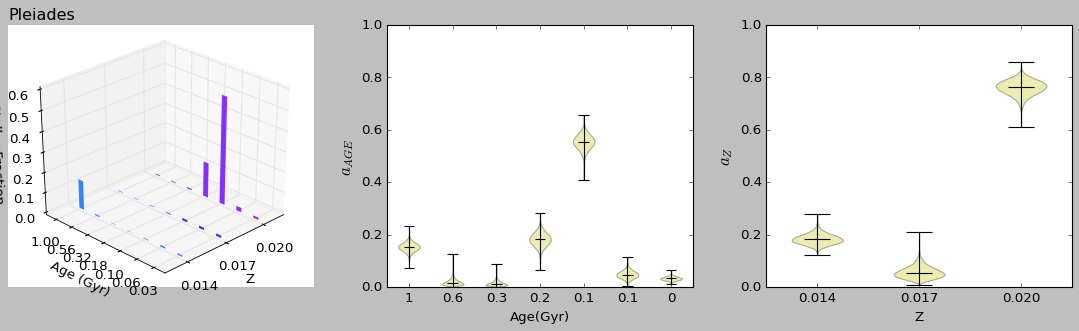

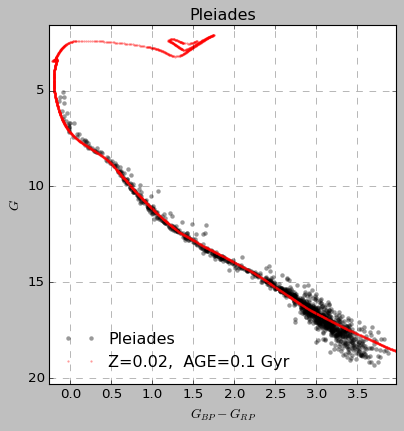

In [4]:
from scipy import genfromtxt, special
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys
import pystan
import pickle
##
#import SFH_3D_plot_no_scaled as sf3p_ns
#import Marginal_SFH_Bar_NoScale as mgl_b_ns
#path = os.getcwd()

try:
    dt, list_iso, it_title = sys.argv[1], sys.argv[2], sys.argv[3]
    name = dt[:dt.find('.txt')]
except:
    url = 'https://raw.githubusercontent.com/sundarjhu/DAWGI_Lectures_2021/main/Demo_DAWGI_HBM/Pleiades/'
    name = url + 'Pleiades_ruwe_cexcess_SelDist.txt'
    list_iso = url + 'List_Iso21_PARSEC_GaiaEDR3.txt'
    it_title = 'Pleiades'

print('file: ', name)


######################## Integration rutine ########################
def trapz(yt,xt):
    del_x = xt[1:]-xt[:len(xt)-1]
    y2 = 0.5*(yt[1:]+yt[:len(yt)-1])
    return sum(y2*del_x)





##########################################################################################################################
################################################### PDF DEFINITION #######################################################
##########################################################################################################################


######################## Likelihood ########################
def Normal_MGk(gk_dat,gk_err,Iso_sig):                  ## Like apparente magnitude
    sig2 = gk_err*gk_err+Iso_sig*Iso_sig
    return  lambda gk_iso : np.exp( -0.5*(gk_dat-gk_iso)**2 / sig2 ) / np.sqrt(2.*np.pi*sig2)


def Phi_MGk(gkj2, sig_gkj2, gklim, sig_i2):             ## Limit magnitude function.
    b = sig_i2*sig_i2+sig_gkj2*sig_gkj2
    b1 = sig_i2*sig_i2/b
    b2 = sig_gkj2*sig_gkj2/b
    b3 = sig_i2*sig_gkj2/np.sqrt(b)
    return  lambda gk_i2 : special.ndtr( ( gklim - b1*gkj2 - b2*gk_i2 ) / b3 )



########################## Priors #############################
def IMF_Krp(m,ml=0.1,mint=0.5,mu=100.,a1=1.3,a2=2.3):   ##    IMF Kroupa

    h2 = (mu**(1.-a2)-mint**(1.-a2))/(1.-a2)
    h1 = (mint**(1.-a1)-ml**(1.-a1))/(1.-a1)

    c1 = 1./(h1+h2*mint**(a2-a1))
    c2 = c1*mint**(a2-a1)

    c = np.ones(len(m))
    c[np.where(m < mint)] = c1
    c[np.where(m >= mint)] = c2

    a = np.ones(len(m))
    a[np.where(m < mint)] = -a1
    a[np.where(m >= mint)] = -a2
    
    imf = c*m**a
    
    return imf

def IMF_Salp(m, xs=1.35, ml0=0.1, mu0=100.):            ## IMF Salpeter
    cte=-xs/(mu0**(-xs)-ml0**(-xs))
    return cte*m**(-1.-xs) 



############################# Posterior #############################
def P_ij(dat, Ndat, gk1_lim, gk2_lim, gk3_lim, Iso, Niso, sig_i):
    p_ij = []
    for j in range(Ndat):

        P_gk1 = Normal_MGk(dat[2][j],dat[3][j],sig_i)
        P_gk2 = Normal_MGk(dat[4][j],dat[5][j],sig_i)
        P_gk3 = Normal_MGk(dat[6][j],dat[7][j],sig_i)

        Phi_gk1 = Phi_MGk(dat[2][j], dat[3][j], gk1_lim, sig_i)
        Phi_gk2 = Phi_MGk(dat[4][j], dat[5][j], gk2_lim, sig_i)
        Phi_gk3 = Phi_MGk(dat[6][j], dat[7][j], gk3_lim, sig_i)

        pi=[]
        for i in range(Niso):
            Intg = IMF_Krp(Iso[i][0])*P_gk1(Iso[i][1])*P_gk2(Iso[i][2])*P_gk3(Iso[i][3])*Phi_gk1(Iso[i][1])*Phi_gk2(Iso[i][2])*Phi_gk3(Iso[i][3])
            p = trapz(Intg,Iso[i][0])
            pi.append(p)

        p_ij.append(pi)

        if j%200==0:
            print(100.*(float(j)/float(Ndat)),'%')

    p_ij = np.array(p_ij)
    
    return p_ij



################### Normalization constant #####################
def phi(gkk_lim,sig_i4):                                                ## Limit magnitude function.
    return lambda gkk_i4: special.ndtr((gkk_lim-gkk_i4)/sig_i4)

def C_ij(Ndat_c, gk1_lim, gk2_lim, gk3_lim, Iso_c, Niso_c, sig_i):      ## Normalization Constant ##

    phi_gk1c = phi(gk1_lim,sig_i)
    phi_gk2c = phi(gk2_lim,sig_i)
    phi_gk3c = phi(gk3_lim,sig_i)
    
    w=np.array([])
    for i in range(Niso_c):
        intg_c = IMF_Krp(Iso_c[i][0])*phi_gk1c(Iso_c[i][1])*phi_gk2c(Iso_c[i][2])*phi_gk2c(Iso_c[i][3])
        p_c = trapz(intg_c,Iso_c[i][0])
        w = np.append(w,p_c)
    
    return np.array([w for k in range(Ndat_c)])

##########################################################################################################################
##################################################### ISOCRHONES #########################################################
##########################################################################################################################

gk1_lim0 = 20.    ##  27.5  ##   29.
gk2_lim0 = 20.    ##  28.   ##   28.4
gk3_lim0 = 20.

isofilelist = np.genfromtxt(list_iso,dtype='str')

isos0=[]
nn=0
path = url
for k in isofilelist:
    nn+=1
    isos0.append(np.loadtxt(path+k, unpack=True))


N_iso = len(isos0)
print( 'N_iso = ', N_iso )
print( 'N_col = ', len(isos0[0]) )


dismod = 5.667
for j in range(N_iso):
    isos0[j][1]=isos0[j][1]+dismod
    isos0[j][2]=isos0[j][2]+dismod
    isos0[j][3]=isos0[j][3]+dismod

isos = []
for j in range(N_iso):
    f_lim=np.where(isos0[j][1]<=gk1_lim0)
    i_aux = isos0[j].T[f_lim]
    isos.append(i_aux.T)

##########################################################################################################################
#####################################################    DATA    #########################################################
##########################################################################################################################
#    0         1        2      3      4      5       6      7
#   Plx    Plx_error    G    Gerr    GB    GBerr    GR    GRerr
#dat0 = np.loadtxt(dt, unpack = True)
dat0 = np.loadtxt(name, unpack = True)

dat0[2] = dat0[2]-0.11        ## Extinction correction
dat0[4] = dat0[4]-0.14
dat0[6] = dat0[6]-0.083

gk_filter = np.where(dat0[2]<=gk1_lim0)
dat = dat0.T[gk_filter]
dat = dat.T

N_dat = len(dat[0])
print( 'N_dat = ', N_dat )

##########################################################################################################################
################################################### Pij CALCULATION ######################################################
##########################################################################################################################
print( ' ' )

sig_i0 = 0.05

print( 'Calculating Cij ...' )
cc = C_ij(N_dat, gk1_lim0, gk2_lim0, gk3_lim0, isos, N_iso, sig_i0)
print( 'C_ij = ', len(cc), len(cc[0]) )
print( 'Cij end.' )

print( ' ' )

print( 'Calculating Pij ...' )
start = time.time()
pp=P_ij(dat, N_dat, gk1_lim0, gk2_lim0, gk3_lim0, isos, N_iso, sig_i0)
end = time.time()
print( (end - start)/60., 'mins' )
print( 'P_ij = ', len(pp), len(pp[0]) )
print( 'Pij end.' )

print( ' ' )

##########################################################################################################################
################################################# POSTERIOR SAMPLING #####################################################
##########################################################################################################################


############ Stan code ############
code = """

functions{
    real P(int N1, int N2, vector v, matrix M) {
       vector[N1] Mj;
        vector[N1] ln_Mj;

        Mj= M*v;
        for (j in 1:N1){
            if (Mj[j]<=0.)
                Mj[j] = 1.;
        }
        ln_Mj = log(Mj);
        return sum(ln_Mj);
    }
}

data {
    int<lower=0> Nj; // number of data
    int<lower=0> Ni; // number of isochrones
    matrix[Nj,Ni] Pij; // Probability matrix
    matrix[Nj,Ni] Cij; // Normalization matrix
}

parameters {
    simplex[Ni] a;
}

model {
    target += dirichlet_lpdf(a | rep_vector(1., Ni));
    target += P(Nj,Ni,a,Pij);
    target += -1.*P(Nj,Ni,a,Cij);
}

"""

dats = {'Nj' : N_dat,
        'Ni' : N_iso,
        'Pij': pp,
        'Cij': cc  }



############ Running pystan ############
if not os.path.isfile('model.pkl'):
    print( 'model.pkl does not exist' )
    sm = pystan.StanModel(model_code=code)

    print( 'Star sampling' )
    start = time.time()
    fit = sm.sampling(data=dats, iter=1000, chains=50, n_jobs=-1)
    end = time.time()
    print( (end - start), 's' )
    
    sp = fit.extract(permuted=True)

    with open('model.pkl', 'wb') as f:
        pickle.dump(sm, f)

else:
    print( 'model.pkl do exist' )
    sm = pickle.load(open('model.pkl', 'rb'))

    print( 'Star sampling' )
    start = time.time()
    fit = sm.sampling(data=dats, iter=1000, chains=50, n_jobs=-1)
    end = time.time()
    print( (end - start), 's' )
    
    sp = fit.extract(permuted=True)



######### Saving the MCMC sample #########
a_sp = sp['a']

N_iso = len(a_sp[0])
print( 'a_col =', N_iso )

print( 'a_row =', len(a_sp) )

#np.savetxt("ai_sampling_"+name+"_Iso21_sig_i0.05.txt", a_sp, fmt="%.6f", delimiter="  ")





##########################################################################################################################
################################################ PLOTS AND STATISTICS ####################################################
##########################################################################################################################


################# Star formation history (SFH) #################


a_perc = np.array([ np.percentile(ai,[10,50,90]) for ai in a_sp.T])       ##  10th, 50th, 90th percentiles


sfh=[]
#f = open(list_iso, 'r')
#for n,fi in zip(range(N_iso),f):
for n,fi in zip(range(N_iso), isofilelist):
    Zi   = float('0.'+fi[fi.find('Z.')+2:fi.find('_AGE')])
    AGEi = float(fi[fi.find('_AGE')+4:fi.find('Gyr')])
    sfh.append([Zi,AGEi,a_perc[n][0],a_perc[n][1],a_perc[n][2]])

sfh=np.array(sfh)

#hd='       Z       age        p10        p50       p90'
#np.savetxt("SFH_"+name+"_sigIso0.05.txt", sfh, fmt="%.6f", header=hd, delimiter="  ")      ##  Save SFH




#################### SFH plot ####################
fig = plt.figure(1,figsize=(14,4))

#sf3p_ns.sfh_plot_mode(name,sfh.T[0],sfh.T[1],sfh.T[3],'median',fig)    ###  Age-Metalicity relation
sfh_plot_mode(name,sfh.T[0],sfh.T[1],sfh.T[3],'median',fig)    ###  Age-Metalicity relation
plt.title(it_title, loc='left', fontsize='large')
#mgl_b_ns.marg_sfh_bar_age(name,sfh.T,a_sp,fig)                         ###  SFH
#mgl_b_ns.marg_sfh_bar_Z(name,sfh.T,a_sp,N_iso,fig)                     ###  Metal distribution
marg_sfh_bar_age(name,sfh.T,a_sp,fig)                         ###  SFH
marg_sfh_bar_Z(name,sfh.T,a_sp,N_iso,fig)                     ###  Metal distribution

plt.subplots_adjust(left=0.03, bottom=0.12, right=0.98, top=0.94, wspace=0.24, hspace=0.20)
#plt.savefig('SFH_'+name+'_'+str(sig_i0)+'.png')
#plt.close(1)
plt.show()



###########  Color-magnitude diagram  ############

#### Isocrone ####
idn_max = np.argmax(sfh[:,3])   ## Maximum p50 - iscocrone contribution

Z_max = sfh[:,0][idn_max]
AGE_max = sfh[:,1][idn_max]

lgn="Z="+str(Z_max)+",  AGE="+str(AGE_max)+" Gyr"   ## Isocrone legend

Iso_max = isos[idn_max]
col_iso, mag_iso = Iso_max[2]-Iso_max[3], Iso_max[1]   ## Colour and magnitudes


###### Data ######
col_dat = dat0[4]-dat0[6]
mag_dat = dat0[2]


##################

plt.figure(2,figsize=(5.6,5.6))

plt.plot(col_dat, mag_dat, 'ko', markersize=4, markeredgewidth=0., alpha=0.4, label = it_title)   ## Data CMD
plt.plot(col_iso, mag_iso,'ro', markersize=2, markeredgewidth=0., alpha=0.4, label = lgn)         ## Iso CMD

sz=15
plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G$')

min_x ,min_y = min(np.min(col_dat),np.min(col_iso)), min(np.min(mag_dat),np.min(mag_iso))
max_x ,max_y = max(np.max(col_dat),np.max(col_iso)), max(np.max(mag_dat),np.max(mag_iso))

plt.xlim(min_x+0.2,max_x-0.2)
plt.ylim(max_y+0.5,min_y-0.5)
plt.grid(linestyle='--', alpha=0.5)
plt.title(it_title)
plt.legend(frameon=False, loc=0)
#plt.savefig('CMD_'+it_title+'.png')
plt.show()

##Run the code again, this time for limiting magnitudes of 15 mag in each Gaia band.

file:  https://raw.githubusercontent.com/sundarjhu/DAWGI_Lectures_2021/main/Demo_DAWGI_HBM/Pleiades/Pleiades_ruwe_cexcess_SelDist.txt
N_iso =  21
N_col =  4
N_dat =  403
 
Calculating Cij ...
C_ij =  403 21
Cij end.
 
Calculating Pij ...
0.0 %
49.62779156327544 %
99.25558312655087 %
0.12113152345021566 mins
P_ij =  403 21
Pij end.
 
model.pkl do exist
Star sampling
75.46145701408386 s
a_col = 21
a_row = 25000


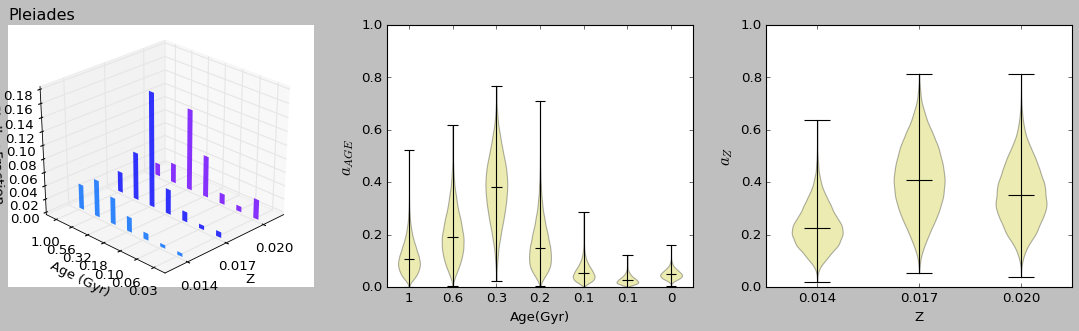

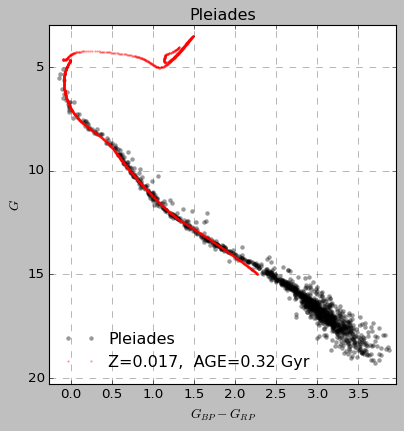

In [5]:
from scipy import genfromtxt, special
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys
import pystan
import pickle
##
#import SFH_3D_plot_no_scaled as sf3p_ns
#import Marginal_SFH_Bar_NoScale as mgl_b_ns
#path = os.getcwd()

try:
    dt, list_iso, it_title = sys.argv[1], sys.argv[2], sys.argv[3]
    name = dt[:dt.find('.txt')]
except:
    url = 'https://raw.githubusercontent.com/sundarjhu/DAWGI_Lectures_2021/main/Demo_DAWGI_HBM/Pleiades/'
    name = url + 'Pleiades_ruwe_cexcess_SelDist.txt'
    list_iso = url + 'List_Iso21_PARSEC_GaiaEDR3.txt'
    it_title = 'Pleiades'

print('file: ', name)


######################## Integration rutine ########################
def trapz(yt,xt):
    del_x = xt[1:]-xt[:len(xt)-1]
    y2 = 0.5*(yt[1:]+yt[:len(yt)-1])
    return sum(y2*del_x)





##########################################################################################################################
################################################### PDF DEFINITION #######################################################
##########################################################################################################################


######################## Likelihood ########################
def Normal_MGk(gk_dat,gk_err,Iso_sig):                  ## Like apparente magnitude
    sig2 = gk_err*gk_err+Iso_sig*Iso_sig
    return  lambda gk_iso : np.exp( -0.5*(gk_dat-gk_iso)**2 / sig2 ) / np.sqrt(2.*np.pi*sig2)


def Phi_MGk(gkj2, sig_gkj2, gklim, sig_i2):             ## Limit magnitude function.
    b = sig_i2*sig_i2+sig_gkj2*sig_gkj2
    b1 = sig_i2*sig_i2/b
    b2 = sig_gkj2*sig_gkj2/b
    b3 = sig_i2*sig_gkj2/np.sqrt(b)
    return  lambda gk_i2 : special.ndtr( ( gklim - b1*gkj2 - b2*gk_i2 ) / b3 )



########################## Priors #############################
def IMF_Krp(m,ml=0.1,mint=0.5,mu=100.,a1=1.3,a2=2.3):   ##    IMF Kroupa

    h2 = (mu**(1.-a2)-mint**(1.-a2))/(1.-a2)
    h1 = (mint**(1.-a1)-ml**(1.-a1))/(1.-a1)

    c1 = 1./(h1+h2*mint**(a2-a1))
    c2 = c1*mint**(a2-a1)

    c = np.ones(len(m))
    c[np.where(m < mint)] = c1
    c[np.where(m >= mint)] = c2

    a = np.ones(len(m))
    a[np.where(m < mint)] = -a1
    a[np.where(m >= mint)] = -a2
    
    imf = c*m**a
    
    return imf

def IMF_Salp(m, xs=1.35, ml0=0.1, mu0=100.):            ## IMF Salpeter
    cte=-xs/(mu0**(-xs)-ml0**(-xs))
    return cte*m**(-1.-xs) 



############################# Posterior #############################
def P_ij(dat, Ndat, gk1_lim, gk2_lim, gk3_lim, Iso, Niso, sig_i):
    p_ij = []
    for j in range(Ndat):

        P_gk1 = Normal_MGk(dat[2][j],dat[3][j],sig_i)
        P_gk2 = Normal_MGk(dat[4][j],dat[5][j],sig_i)
        P_gk3 = Normal_MGk(dat[6][j],dat[7][j],sig_i)

        Phi_gk1 = Phi_MGk(dat[2][j], dat[3][j], gk1_lim, sig_i)
        Phi_gk2 = Phi_MGk(dat[4][j], dat[5][j], gk2_lim, sig_i)
        Phi_gk3 = Phi_MGk(dat[6][j], dat[7][j], gk3_lim, sig_i)

        pi=[]
        for i in range(Niso):
            Intg = IMF_Krp(Iso[i][0])*P_gk1(Iso[i][1])*P_gk2(Iso[i][2])*P_gk3(Iso[i][3])*Phi_gk1(Iso[i][1])*Phi_gk2(Iso[i][2])*Phi_gk3(Iso[i][3])
            p = trapz(Intg,Iso[i][0])
            pi.append(p)

        p_ij.append(pi)

        if j%200==0:
            print(100.*(float(j)/float(Ndat)),'%')

    p_ij = np.array(p_ij)
    
    return p_ij



################### Normalization constant #####################
def phi(gkk_lim,sig_i4):                                                ## Limit magnitude function.
    return lambda gkk_i4: special.ndtr((gkk_lim-gkk_i4)/sig_i4)

def C_ij(Ndat_c, gk1_lim, gk2_lim, gk3_lim, Iso_c, Niso_c, sig_i):      ## Normalization Constant ##

    phi_gk1c = phi(gk1_lim,sig_i)
    phi_gk2c = phi(gk2_lim,sig_i)
    phi_gk3c = phi(gk3_lim,sig_i)
    
    w=np.array([])
    for i in range(Niso_c):
        intg_c = IMF_Krp(Iso_c[i][0])*phi_gk1c(Iso_c[i][1])*phi_gk2c(Iso_c[i][2])*phi_gk2c(Iso_c[i][3])
        p_c = trapz(intg_c,Iso_c[i][0])
        w = np.append(w,p_c)
    
    return np.array([w for k in range(Ndat_c)])

##########################################################################################################################
##################################################### ISOCRHONES #########################################################
##########################################################################################################################

gk1_lim0 = 15.
gk2_lim0 = 15.
gk3_lim0 = 15.

isofilelist = np.genfromtxt(list_iso,dtype='str')

isos0=[]
nn=0
path = url
for k in isofilelist:
    nn+=1
    isos0.append(np.loadtxt(path+k, unpack=True))


N_iso = len(isos0)
print( 'N_iso = ', N_iso )
print( 'N_col = ', len(isos0[0]) )


dismod = 5.667
for j in range(N_iso):
    isos0[j][1]=isos0[j][1]+dismod
    isos0[j][2]=isos0[j][2]+dismod
    isos0[j][3]=isos0[j][3]+dismod

isos = []
for j in range(N_iso):
    f_lim=np.where(isos0[j][1]<=gk1_lim0)
    i_aux = isos0[j].T[f_lim]
    isos.append(i_aux.T)

##########################################################################################################################
#####################################################    DATA    #########################################################
##########################################################################################################################
#    0         1        2      3      4      5       6      7
#   Plx    Plx_error    G    Gerr    GB    GBerr    GR    GRerr
#dat0 = np.loadtxt(dt, unpack = True)
dat0 = np.loadtxt(name, unpack = True)

dat0[2] = dat0[2]-0.11        ## Extinction correction
dat0[4] = dat0[4]-0.14
dat0[6] = dat0[6]-0.083

gk_filter = np.where(dat0[2]<=gk1_lim0)
dat = dat0.T[gk_filter]
dat = dat.T

N_dat = len(dat[0])
print( 'N_dat = ', N_dat )

##########################################################################################################################
################################################### Pij CALCULATION ######################################################
##########################################################################################################################
print( ' ' )

sig_i0 = 0.05

print( 'Calculating Cij ...' )
cc = C_ij(N_dat, gk1_lim0, gk2_lim0, gk3_lim0, isos, N_iso, sig_i0)
print( 'C_ij = ', len(cc), len(cc[0]) )
print( 'Cij end.' )

print( ' ' )

print( 'Calculating Pij ...' )
start = time.time()
pp=P_ij(dat, N_dat, gk1_lim0, gk2_lim0, gk3_lim0, isos, N_iso, sig_i0)
end = time.time()
print( (end - start)/60., 'mins' )
print( 'P_ij = ', len(pp), len(pp[0]) )
print( 'Pij end.' )

print( ' ' )

##########################################################################################################################
################################################# POSTERIOR SAMPLING #####################################################
##########################################################################################################################


############ Stan code ############
code = """

functions{
    real P(int N1, int N2, vector v, matrix M) {
       vector[N1] Mj;
        vector[N1] ln_Mj;

        Mj= M*v;
        for (j in 1:N1){
            if (Mj[j]<=0.)
                Mj[j] = 1.;
        }
        ln_Mj = log(Mj);
        return sum(ln_Mj);
    }
}

data {
    int<lower=0> Nj; // number of data
    int<lower=0> Ni; // number of isochrones
    matrix[Nj,Ni] Pij; // Probability matrix
    matrix[Nj,Ni] Cij; // Normalization matrix
}

parameters {
    simplex[Ni] a;
}

model {
    target += dirichlet_lpdf(a | rep_vector(1., Ni));
    target += P(Nj,Ni,a,Pij);
    target += -1.*P(Nj,Ni,a,Cij);
}

"""

dats = {'Nj' : N_dat,
        'Ni' : N_iso,
        'Pij': pp,
        'Cij': cc  }



############ Running pystan ############
if not os.path.isfile('model.pkl'):
    print( 'model.pkl does not exist' )
    sm = pystan.StanModel(model_code=code)

    print( 'Star sampling' )
    start = time.time()
    fit = sm.sampling(data=dats, iter=1000, chains=50, n_jobs=-1)
    end = time.time()
    print( (end - start), 's' )
    
    sp = fit.extract(permuted=True)

    with open('model.pkl', 'wb') as f:
        pickle.dump(sm, f)

else:
    print( 'model.pkl do exist' )
    sm = pickle.load(open('model.pkl', 'rb'))

    print( 'Star sampling' )
    start = time.time()
    fit = sm.sampling(data=dats, iter=1000, chains=50, n_jobs=-1)
    end = time.time()
    print( (end - start), 's' )
    
    sp = fit.extract(permuted=True)



######### Saving the MCMC sample #########
a_sp = sp['a']

N_iso = len(a_sp[0])
print( 'a_col =', N_iso )

print( 'a_row =', len(a_sp) )

#np.savetxt("ai_sampling_"+name+"_Iso21_sig_i0.05.txt", a_sp, fmt="%.6f", delimiter="  ")





##########################################################################################################################
################################################ PLOTS AND STATISTICS ####################################################
##########################################################################################################################


################# Star formation history (SFH) #################


a_perc = np.array([ np.percentile(ai,[10,50,90]) for ai in a_sp.T])       ##  10th, 50th, 90th percentiles


sfh=[]
#f = open(list_iso, 'r')
#for n,fi in zip(range(N_iso),f):
for n,fi in zip(range(N_iso), isofilelist):
    Zi   = float('0.'+fi[fi.find('Z.')+2:fi.find('_AGE')])
    AGEi = float(fi[fi.find('_AGE')+4:fi.find('Gyr')])
    sfh.append([Zi,AGEi,a_perc[n][0],a_perc[n][1],a_perc[n][2]])

sfh=np.array(sfh)

#hd='       Z       age        p10        p50       p90'
#np.savetxt("SFH_"+name+"_sigIso0.05.txt", sfh, fmt="%.6f", header=hd, delimiter="  ")      ##  Save SFH




#################### SFH plot ####################
fig = plt.figure(1,figsize=(14,4))

#sf3p_ns.sfh_plot_mode(name,sfh.T[0],sfh.T[1],sfh.T[3],'median',fig)    ###  Age-Metalicity relation
sfh_plot_mode(name,sfh.T[0],sfh.T[1],sfh.T[3],'median',fig)    ###  Age-Metalicity relation
plt.title(it_title, loc='left', fontsize='large')
#mgl_b_ns.marg_sfh_bar_age(name,sfh.T,a_sp,fig)                         ###  SFH
#mgl_b_ns.marg_sfh_bar_Z(name,sfh.T,a_sp,N_iso,fig)                     ###  Metal distribution
marg_sfh_bar_age(name,sfh.T,a_sp,fig)                         ###  SFH
marg_sfh_bar_Z(name,sfh.T,a_sp,N_iso,fig)                     ###  Metal distribution

plt.subplots_adjust(left=0.03, bottom=0.12, right=0.98, top=0.94, wspace=0.24, hspace=0.20)
#plt.savefig('SFH_'+name+'_'+str(sig_i0)+'.png')
#plt.close(1)
plt.show()



###########  Color-magnitude diagram  ############

#### Isocrone ####
idn_max = np.argmax(sfh[:,3])   ## Maximum p50 - iscocrone contribution

Z_max = sfh[:,0][idn_max]
AGE_max = sfh[:,1][idn_max]

lgn="Z="+str(Z_max)+",  AGE="+str(AGE_max)+" Gyr"   ## Isocrone legend

Iso_max = isos[idn_max]
col_iso, mag_iso = Iso_max[2]-Iso_max[3], Iso_max[1]   ## Colour and magnitudes


###### Data ######
col_dat = dat0[4]-dat0[6]
mag_dat = dat0[2]


##################

plt.figure(2,figsize=(5.6,5.6))

plt.plot(col_dat, mag_dat, 'ko', markersize=4, markeredgewidth=0., alpha=0.4, label = it_title)   ## Data CMD
plt.plot(col_iso, mag_iso,'ro', markersize=2, markeredgewidth=0., alpha=0.4, label = lgn)         ## Iso CMD

sz=15
plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G$')

min_x ,min_y = min(np.min(col_dat),np.min(col_iso)), min(np.min(mag_dat),np.min(mag_iso))
max_x ,max_y = max(np.max(col_dat),np.max(col_iso)), max(np.max(mag_dat),np.max(mag_iso))

plt.xlim(min_x+0.2,max_x-0.2)
plt.ylim(max_y+0.5,min_y-0.5)
plt.grid(linestyle='--', alpha=0.5)
plt.title(it_title)
plt.legend(frameon=False, loc=0)
#plt.savefig('CMD_'+it_title+'.png')
plt.show()

Copyright 2021 Jairo Andrés Alzate Trujillo

Permission is hereby granted, free of charge, to any person obtaining a copy of 
this software and associated documentation files (the "Software"), to deal in 
the Software without restriction, including without limitation the rights to 
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of 
the Software, and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all 
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS 
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR 
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER 
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.